Neighborhood analysis is a powerful approach in spatial biology that explores how cells interact with their local microenvironment. Using Histolytics, users can quantitatively assess the spatial relationships and organizational patterns of cells within tissue sections. Key analyses include:

- **Link counts:**
Count the number of specific cell-cell links (e.g., immune-to-neoplastic) within a defined radius, providing insights into cellular interactions and potential functional relationships.

- **Custom Metrics:**
Develop and implement custom metrics tailored to specific research questions, enabling more nuanced analyses of spatial relationships and cellular interactions.

- **Neighborhood Characteristics:**  
Identify and quantify the summary characteristics of neighboring nuclei surrounding a given nucleus, 

- **Neighborhood Distances:**  
Measure distances between nuclei or between a nuclei and its neighbors, enabling the study of spatial proximity.

- **Diversity and Heterogeneity:**  
Calculate neighborhood diversity metrics (e.g., Shannon entropy) to assess the heterogeneity of cell types or cell characteristics within a defined radius, providing insights into tissue complexity and organization.

These analyses help uncover the spatial context of cellular interactions for understanding tissue function, disease progression, and the tumor microenvironment. Histolytics streamlines these workflows.

## Spatial Weights

To analyze neighborhoods of segmented nuclei, we first need to fit a connectivity graph to the `GeoDataFrame` to get the neighborhoods of the nuclei (sometimes it is called spatial weights in geospatial analysis jargon). `histolytics` provides a `fit_graph` function which can be used to do that. The actual fitting is done with the `libpysal` package and the `fit_graph`-function is basically a wrapper around different graph fitting methods. The allowed spatial weights are:

- `knn`: k-nearest neighbors
- `delaunay` - Delaunay triangulation
- `distband` - Distance band i.e. a distance thresholded knn graph
- `relative_nhood` - Relative neighborhood graph
- `gabriel` - Gabriel graph
- `voronoi` - Voronoi graph

We will be using the `delaunay` method in this example. Here, we will set a distance threshold for the neighbors to be within 50 microns of the nuclei centroid. The distance unit in the example data is in pixels so 50 microns in pixels of 20x magnified segmentation mask is around 50*2 = 100 pixels.

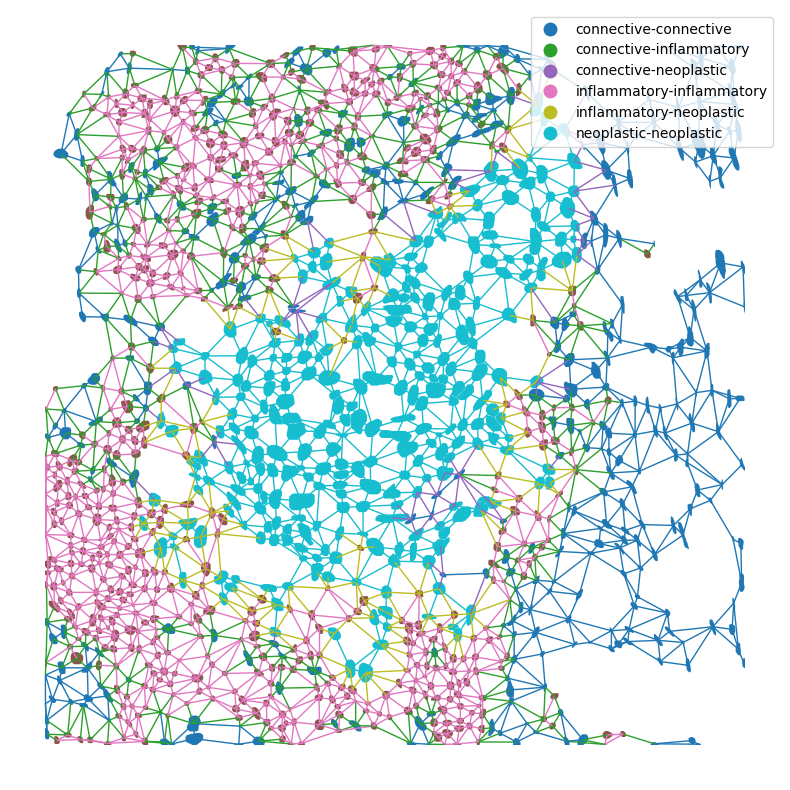

In [1]:
from histolytics.spatial_graph.graph import fit_graph
from histolytics.utils.gdf import set_uid
from histolytics.data import hgsc_cancer_nuclei

nuc = hgsc_cancer_nuclei()
nuc = set_uid(nuc)  # Ensure the GeoDataFrame has a unique identifier

# fit spatial weights using Delaunay triangulation
w, w_gdf = fit_graph(nuc, "delaunay", id_col="uid", threshold=100)
ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
w_gdf.plot(ax=ax, linewidth=1, column="class_name", legend=True, aspect=1)
w_gdf.head(5)
ax.set_axis_off()

## Link counts

The cell-cell link counts are easily extracted from the `w_gdf` by using pandas:

In [2]:
# Link counts
w_gdf.value_counts("class_name")

class_name
inflammatory-inflammatory    1347
connective-inflammatory       748
neoplastic-neoplastic         692
connective-connective         582
inflammatory-neoplastic       228
connective-neoplastic          81
Name: count, dtype: int64

We will select only the immune-neoplatic links to see whether there is potential interaction between immune and neoplastic cells.

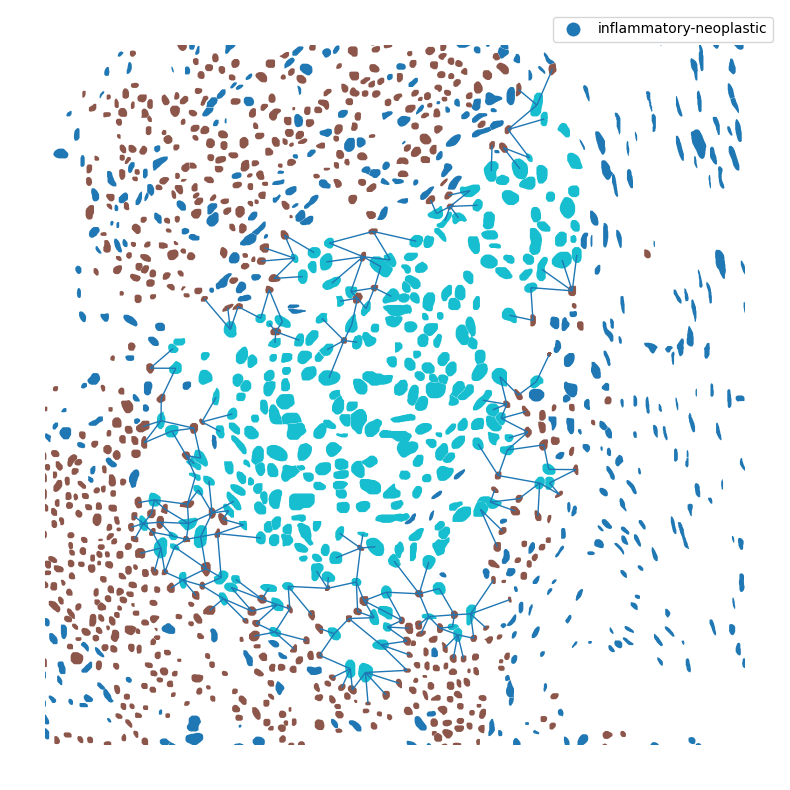

In [3]:
imm_neo_links = w_gdf[w_gdf["class_name"] == "inflammatory-neoplastic"]

ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
imm_neo_links.plot(ax=ax, linewidth=1, column="class_name", legend=True, aspect=1)
ax.set_axis_off()

As seen from the image above, there exists a significant number of links between immune (brown) and neoplastic (cyan) nuclei, indicating potential immune infiltration, which has been shown to correlate with patient outcomes in many cancers.

## Custom Metrics

### Neoplastic Immune-accessibility

Next, we'll showcase how you can create custom metrics to analyze spatial neighborhood relationships between nuclei. We will define a custom metric to analyze the local inflammatory and connective nuclear microenvironment around the neoplastic nuclei. This metric will help us understand how neoplastic nuclei are surrounded by inflammatory and connective tissue cells and potentially physically blocked from immune infiltration. To do this, we calculate for each neoplastic nucleus, the ratio of inflammatory neighbors to the total number of inflammatory and connective neighbors. This highlights neoplastic nuclei that are surrounded predominantly by inflammatory nuclei versus connective nuclei, providing insights whether the neoplastic nuclei are physically blocked by the connective nuclei.

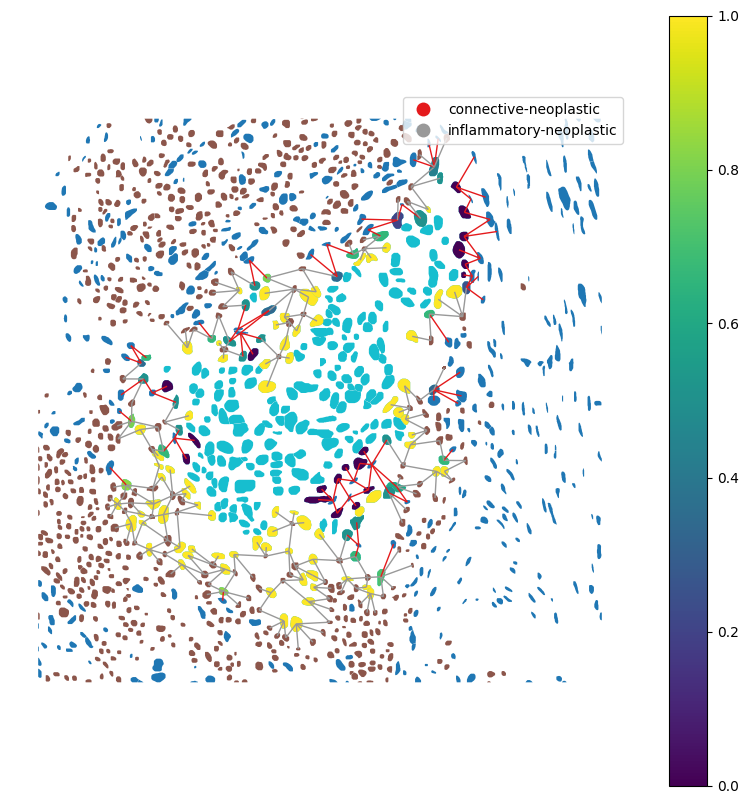

In [4]:
import numpy as np
import pandas as pd
from typing import List, Tuple
from histolytics.spatial_agg.local_values import local_vals


# Custom function to compute the ratio of inflammatory to connective neighbors
def compute_inflammatory_ratio(row):
    if row["inflammatory_cnt"] == 0 and row["connective_cnt"] == 0:
        return 0
    return row["inflammatory_cnt"] / (row["inflammatory_cnt"] + row["connective_cnt"])


def compute_neighbor_cnt(nhood_classes: List[str]) -> Tuple[float, float]:
    inflammatory_count = np.sum(np.array(nhood_classes) == "inflammatory")
    connective_count = np.sum(np.array(nhood_classes) == "connective")
    return inflammatory_count, connective_count


# get the neighborhood classes for each nucleus
nuc = local_vals(
    nuc, w, val_col="class_name", new_col_name="nhood_classes", id_col="uid"
)

# Filter for neoplastic nuclei
neo_nuc = nuc[nuc["class_name"] == "neoplastic"].copy()

# Compute neighborhood inflammatory and connective counts
neo_nuc[["inflammatory_cnt", "connective_cnt"]] = (
    neo_nuc["nhood_classes"].apply(compute_neighbor_cnt).apply(pd.Series)
)

# Compute the ratio of inflammatory to connective neighbors around neoplastic nuclei
neo_nuc["inflammatory_ratio"] = neo_nuc.apply(compute_inflammatory_ratio, axis=1)

# keep only the neoplastic nuclei with inflammatory or connective neighbors
filtered_neo_nuc = neo_nuc[
    (neo_nuc["inflammatory_cnt"] > 0) | (neo_nuc["connective_cnt"] > 0)
]

# Filter the links to only include inflammatory-neoplastic and connective-neoplastic
imm_conn_neo_links = w_gdf[
    w_gdf["class_name"].isin(["inflammatory-neoplastic", "connective-neoplastic"])
]

# Let's visualize the neoplastic nuclei with their inflammatory ratio
ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
filtered_neo_nuc.plot(ax=ax, column="inflammatory_ratio", legend=True, aspect=1)
imm_conn_neo_links.plot(
    ax=ax, linewidth=1, column="class_name", legend=True, aspect=1, cmap="Set1"
)
filtered_neo_nuc.head(3)
ax.set_axis_off()

In this example, most of the neoplastic nuclei are surrounded by inflammatory nuclei, making them potentially more susceptible to immune infiltration. This is indicated by the high ratio of yellow to blue nuclei in the image above. The custom metric can be easily adapted to include other cell types or different heuristics based on the research question.

### Neoplastic cell packing density

Next we will quantify the neoplastic cell packing density in the tumor nest by simply counting the number of neoplastic nuclei within a defined radius around each neoplastic nucleus. For example, in HGSC, the cell packing density is heavily related to different tumor growth patterns e.g. solid, papillary etc.. To get the neighborhoods based on radius, we will use the distband graph with 64 pixel threshold (32 microns).

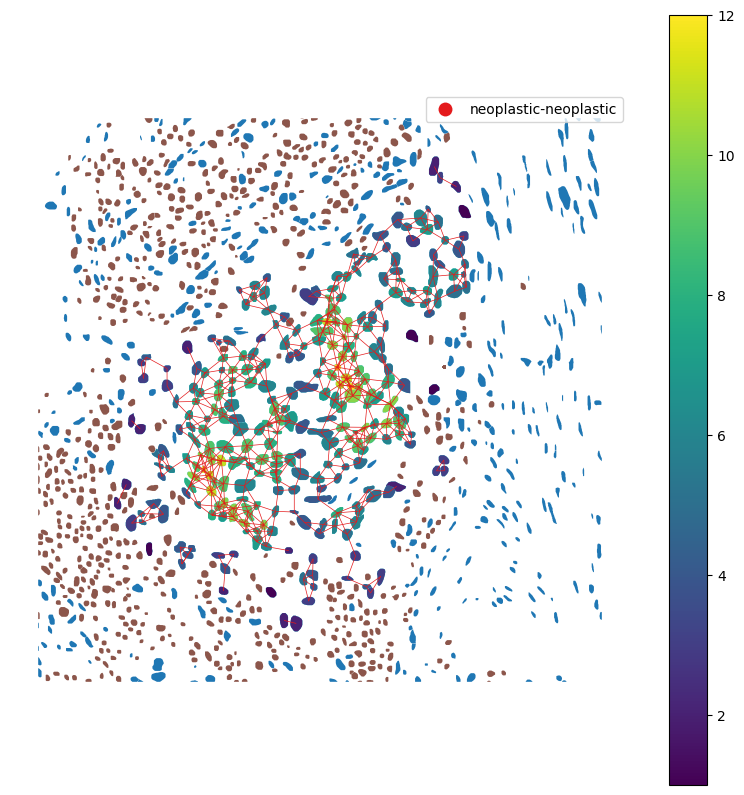

In [5]:
import pandas as pd
from histolytics.spatial_agg.local_values import local_vals


# Custom function to compute the ratio of inflammatory to connective neighbors
def compute_neoplastic_cardinality(row):
    return len(row["nhood_classes"])


# Filter for neoplastic nuclei
neo_nuc = nuc[nuc["class_name"] == "neoplastic"].copy()
neo_nuc = set_uid(neo_nuc)  # Ensure the GeoDataFrame has a unique identifier

# Let's use the distband to get the neighborhoods based on radius only
w, w_gdf = fit_graph(neo_nuc, "distband", id_col="uid", threshold=64)

# get the neighborhood classes for each nucleus
neo_nuc = local_vals(
    neo_nuc, w, val_col="class_name", new_col_name="nhood_classes", id_col="uid"
)

neo_nuc["packing_density"] = neo_nuc.apply(compute_neoplastic_cardinality, axis=1)

# filter the links to only include neoplastic-neoplastic for visualization
neo_neo_links = w_gdf[w_gdf["class_name"].isin(["neoplastic-neoplastic"])]

# Let's visualize the neoplastic nuclei with their inflammatory ratio
ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
neo_nuc.plot(ax=ax, column="packing_density", legend=True, aspect=1)
neo_neo_links.plot(
    ax=ax, linewidth=0.5, column="class_name", legend=True, aspect=1, cmap="Set1"
)
neo_nuc.head(3)
ax.set_axis_off()

Here we see that the neoplastic nuclei are densely packed in the tumor nests, which is typical for this type of solid growth pattern in HGSC. Again, these types of custom metrics can be easily adapted in Histolytics to explore different research questions in mind.

### Link metrics for bigger data.

Next, we'll compute the same metrics but for bigger WSI-level segmentation just to demonstrate scalability.

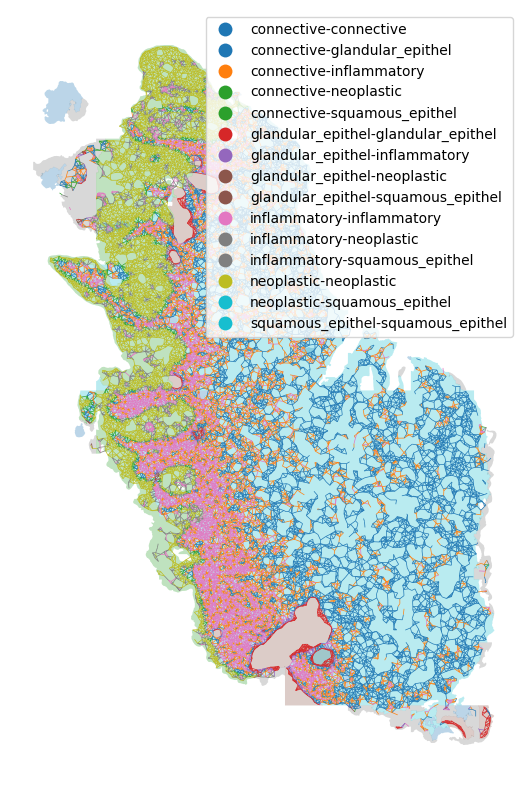

In [6]:
from histolytics.data import cervix_nuclei, cervix_tissue

nuc = cervix_nuclei()
tis = cervix_tissue()  # only for visualization

nuc = set_uid(nuc)  # ensure unique IDs for nuclei
w, w_gdf = fit_graph(nuc, "delaunay", id_col="uid", threshold=100)

# visualize the links on the tissue
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
w_gdf.plot(ax=ax, linewidth=1, column="class_name", legend=True, aspect=1, lw=0.5)
ax.set_axis_off()


Only immune-neoplastic links


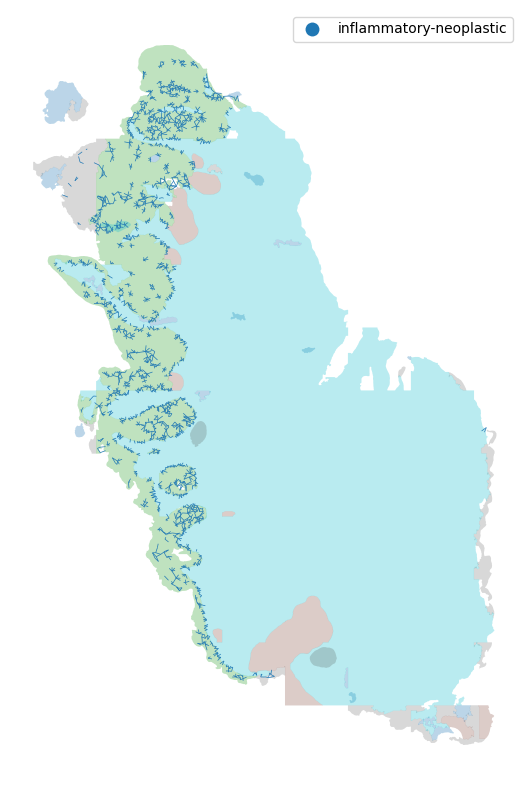

In [7]:
imm_neo_links = w_gdf[w_gdf["class_name"] == "inflammatory-neoplastic"]
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
imm_neo_links.plot(ax=ax, linewidth=0.5, column="class_name", legend=True, aspect=1)
ax.set_axis_off()

In [8]:
w_gdf.value_counts("class_name")

class_name
connective-connective                  15216
connective-inflammatory                12399
inflammatory-inflammatory              11953
neoplastic-neoplastic                   8470
inflammatory-neoplastic                 2526
glandular_epithel-glandular_epithel     1142
connective-neoplastic                    780
glandular_epithel-inflammatory           439
connective-glandular_epithel             382
glandular_epithel-neoplastic              80
connective-squamous_epithel                5
inflammatory-squamous_epithel              2
glandular_epithel-squamous_epithel         1
neoplastic-squamous_epithel                1
squamous_epithel-squamous_epithel          1
Name: count, dtype: int64

Let's compute the immune-accessibility metric for the WSI-level segmentation.

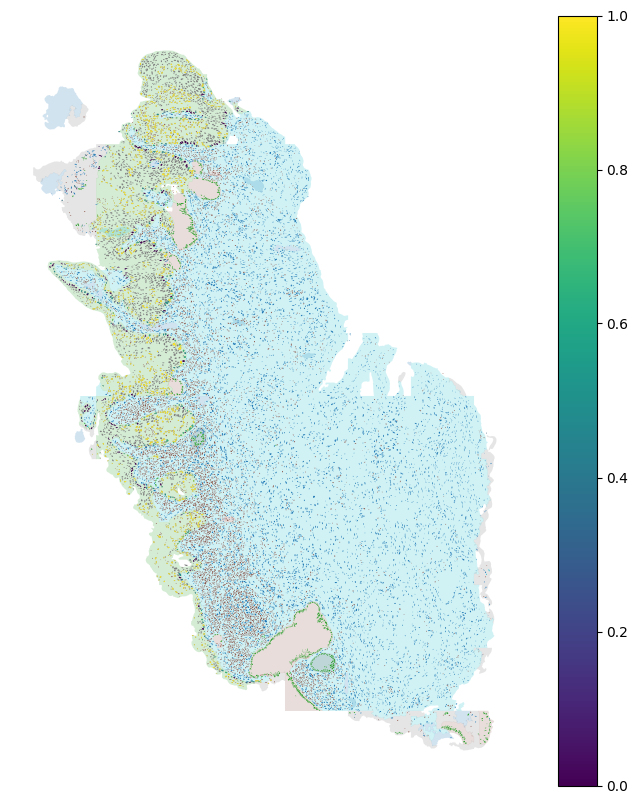

In [9]:
nuc = local_vals(
    nuc, w, val_col="class_name", new_col_name="nhood_classes", id_col="uid"
)

neo_nuc = nuc[nuc["class_name"] == "neoplastic"].copy()
neo_nuc[["inflammatory_cnt", "connective_cnt"]] = (
    neo_nuc["nhood_classes"].apply(compute_neighbor_cnt).apply(pd.Series)
)

neo_nuc["inflammatory_ratio"] = neo_nuc.apply(compute_inflammatory_ratio, axis=1)

filtered_neo_nuc = neo_nuc[
    (neo_nuc["inflammatory_cnt"] > 0) | (neo_nuc["connective_cnt"] > 0)
]
imm_conn_neo_links = w_gdf[
    w_gdf["class_name"].isin(["inflammatory-neoplastic", "connective-neoplastic"])
]

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.2)
ax = nuc.plot(ax=ax, column="class_name", aspect=1)
filtered_neo_nuc.plot(
    ax=ax, column="inflammatory_ratio", legend=True, aspect=1, cmap="viridis"
)
ax.set_axis_off()

Here we see that the majority of neoplastic nuclei bordering stroma, are surrounded by inflammatory nuclei instead of being blocked by connective cells, indicating an activated immune response. 

Let's now get the neoplastic cell packing density.

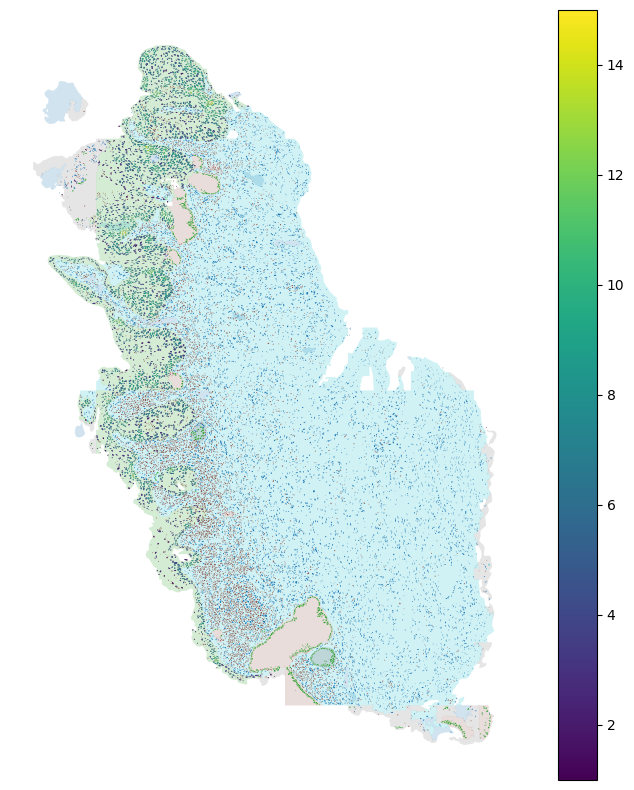

In [10]:
# Filter for neoplastic nuclei
neo_nuc = nuc[nuc["class_name"] == "neoplastic"].copy()
neo_nuc = set_uid(neo_nuc)  # Ensure the GeoDataFrame has a unique identifier

# Let's use the distband to get the neighborhoods based on radius only
w, w_gdf = fit_graph(neo_nuc, "distband", id_col="uid", threshold=64)

# get the neighborhood classes for each nucleus
neo_nuc = local_vals(
    neo_nuc, w, val_col="class_name", new_col_name="nhood_classes", id_col="uid"
)

neo_nuc["packing_density"] = neo_nuc.apply(compute_neoplastic_cardinality, axis=1)

# filter the links to only include neoplastic-neoplastic for visualization
neo_neo_links = w_gdf[w_gdf["class_name"].isin(["neoplastic-neoplastic"])]

# Let's visualize the neoplastic nuclei with their inflammatory ratio
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.2)
ax = nuc.plot(ax=ax, column="class_name", aspect=1)
neo_nuc.plot(ax=ax, column="packing_density", legend=True, aspect=1)
neo_nuc.head(3)
ax.set_axis_off()

We can see that in general, the densely packed regions localize around the basal layer of the epithelial lesion which is expected in cervical lesions.

## Neighborhood Aggregation and Analysis
Next, we will explore how to aggregate nuclei neighborhoods to quantify local microenvironmental features and their spatial distribution.

### Neighborhood Characteristics

If we are interested in the characteristics (features) of neighboring nuclei of a given nucleus, the `local_character` function in Histolytics can be used to compute summary statistics (such as mean, median, or standard deviation) for any quantitative feature (e.g., area, eccentricity) within each cell's spatial neighborhood. By aggregating features across neighbors defined by the spatial graph, users can quantify local microenvironmental characteristics for each nuclei. Here we will compute the mean area of neighboring nuclei for each neoplastic nucleus, providing insights to regional differences in nuclear size.

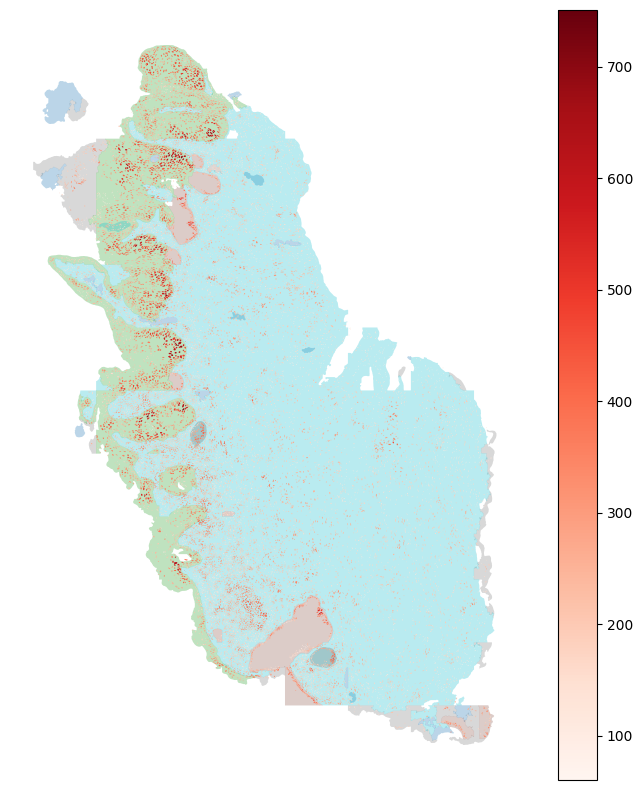

In [11]:
from histolytics.spatial_graph.graph import fit_graph
from histolytics.spatial_geom.shape_metrics import shape_metric
from histolytics.spatial_agg.local_character import local_character


# Calculate shape metrics
nuc = shape_metric(nuc, ["area", "eccentricity"])

# Fit delaunay graph
w, _ = fit_graph(nuc, "delaunay", id_col="uid", threshold=100, use_polars=True)

# Compute local neighborhood summaries for shape metrics
nuc = local_character(
    nuc,
    w,
    val_cols=["area", "eccentricity"],
    id_col="uid",
    reductions=["mean"],
    num_processes=6,
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(ax=ax, column="area_nhood_mean", aspect=1, cmap="Reds", legend=True)
ax.set_axis_off()

In the above image, the more red, the larger the mean area of the neighbors. Here we see that the neoplastic nuclei around the basal layer of the lesion are surrounded by larger nuclei, which is generally expected in cervical lesions. In contrast, the immune dense regions of the stroma are packed with nuclei whose neighborhoods are smaller on average, which is also expected as the immune nuclei are generally far smaller than neoplastic nuclei.

### Neighborhood Distances

To investigate proximities of neighboring nuclei, the `local_distances` function in Histolytics can be used. It allows users to measure euclidean distances between an object and its neighbors. This can provide more details about the spatial organization of nuclei and their potential interactions.

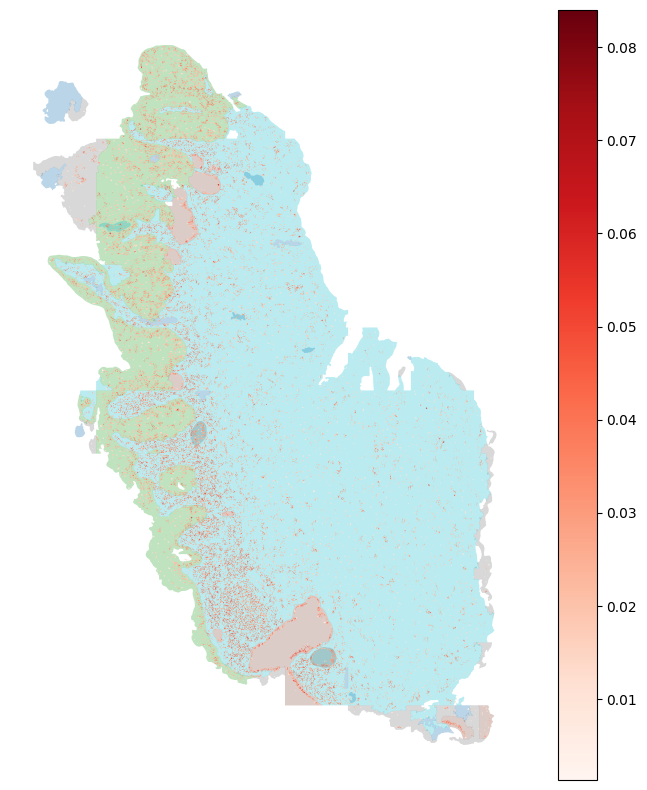

In [12]:
from histolytics.spatial_agg.local_distances import local_distances

# Compute local neighborhood distances
nuc = local_distances(
    nuc,
    w,
    id_col="uid",
    reductions=["median"],
    num_processes=6,
    invert=True,  # invert distances for visualizing densely packed nuclei nhoods
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(ax=ax, column="nhood_dists_median", aspect=1, cmap="Reds", legend=True)
ax.set_axis_off()

In the above image, the more red, the smaller the mean distance to the neighbors (more densely packed). As expected, we see that the neoplastic nuclei around the basal layer of the lesion are more densely packed than the neoplastic nuclei in the superficial layers. Also, we see that the stroma contains densely packed regions mostly consisting of immune cells, which is indicative of activated immune response.

### Neighborhood Diversity and Heterogeneity

To assess the diversity and heterogeneity of nuclear neighborhoods, the `local_diversity` function in Histolytics can be used to compute diversity metrics (e.g., Shannon entropy), quantifying the heterogeneity of nuclei types or characteristics within a defined radius. The diversity measures help to assess complexity and organization of nuclei and can highlight regions of highly diverse nuclear neighborhoods in terms of composition or morphology. The diversity indices can be computed either on categorical or continuous features. When the feature is continuous, the diversity is computed by binning the values into categories.

Supported diversity indices include:  
- `shannon_index` - Shannon entropy
- `simpson_index` - Simpson's diversity index
- `gini_index` - Gini coefficient
- `theil_index` - Theil index


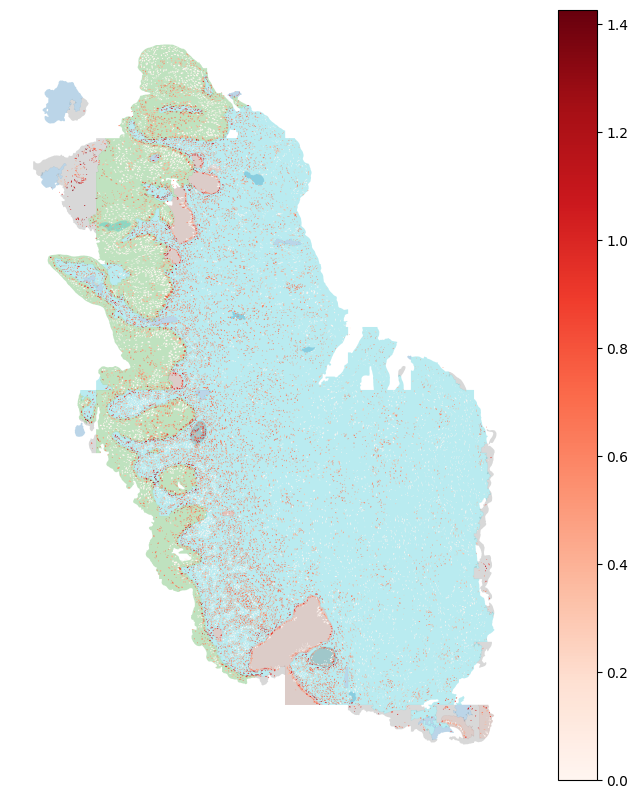

In [13]:
from histolytics.spatial_agg.local_diversity import local_diversity

# Compute local cell type diversity with shannon entropy
nuc = local_diversity(
    nuc,
    w,
    id_col="uid",
    val_cols=["class_name"],
    metrics=["shannon_index"],
    num_processes=6,
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(
    ax=ax, column="class_name_shannon_index", aspect=1, cmap="Reds", legend=True
)
ax.set_axis_off()

In the above image, as expected, the diversity is higher around tissue borders where the stroma meets other tissues. For example, the diversity is higher around the basal layer of the lesion where the neoplastic nuclei have more variable neighborhood compositions (neighborhoods can contain also inflammatory and connective nuclei instead of just neoplastic ones).

Next we will compute the diversity of a contiguous variable. We will use the area of the neighbors in the example. The more red, the more heterogeneous the area of the neighbors.

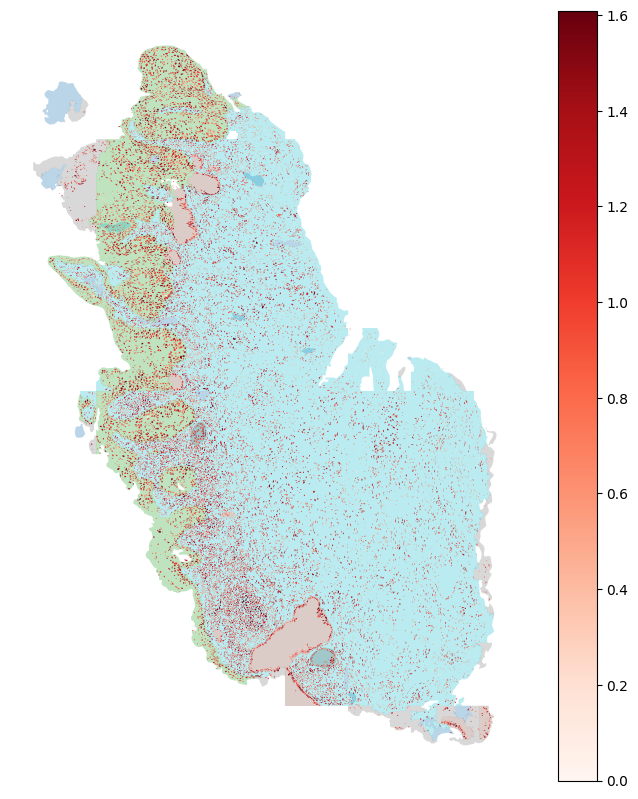

In [14]:
# Compute local cell type diversity with shannon entropy
# We will use fisher-jenks classification to bin the contiguous values for entropy
nuc = local_diversity(
    nuc,
    w,
    id_col="uid",
    val_cols=["area"],
    metrics=["shannon_index"],
    num_processes=6,
    scheme="fisherjenks",
    k=5,
)

# visualize nhood mean areas
ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.3)
ax = nuc.plot(ax=ax, column="area_shannon_index", aspect=1, cmap="Reds", legend=True)
ax.set_axis_off()

We can see in the above image that the nuclear area diversity is relatively high throughout the whole WSI. No apparent regions of low diversity are observed, indicating a consistent level of heterogeneity in nuclear sizes across the tissue.

## Conclusion
In this workflow demonstration, we have shown how Histolytics can be used to analyze spatial relationships between nuclei in histological images. We explored various cell-cell link analyses, including link counts, and custom metrics. We also showed ow to aggregate local neighborhoods of nuclei by computing neighborhood characteristics, distances, and diversity indices. These analyses can provide valuable insights into the spatial organization of cells, their interactions, and the microenvironment in which they reside.